In [1]:
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage import morphology
from scipy import ndimage

from deeplate.MMdata import MMData

In [2]:
folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound'

In [3]:
#create micromanager data object and define metadata
MMobj = MMData(folder = folder)
positions, well = MMobj.get_position_names()
well_index = np.ravel([[x for x in range(well.shape[0]) if well[x] in y] for y in positions])
z_step = MMobj.get_zstep()

In [4]:
#this shows you the order of color acqusition
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [5]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [6]:
path_to_data = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_subset/'
path_to_save = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_subset_stack2/'

In [7]:
totpos = 20
images_to_suppress = [6,11,15,16,17,18,19]
tokeep = list(set(np.arange(20)) -set(images_to_suppress))
numpos = len(tokeep)

In [8]:
mid_plane = int((MMobj.num_planes[bf_ch]-1)/2)

In [9]:
#all_correlations = np.empty((MMobj.height,MMobj.width,numpos))
all_masks = np.empty((MMobj.height, MMobj.width,numpos))
all_weights = np.empty((MMobj.height,MMobj.width,numpos))
all_planes = np.empty((MMobj.height,MMobj.width,21, numpos))

In [10]:
all_masks = np.load(path_to_data+'clean/'+'masks.npy')
all_weights = np.load(path_to_data+'clean/'+'weights.npy')

In [11]:
for i in range(numpos):
    print(i)
    for j in range(21):
        plane = mid_plane-10+j
        all_planes[:,:,j,i] = MMobj.get_image(frame=0,channel=bf_ch,plane=plane,position=tokeep[i], compress = 1)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [12]:
multiply = 1
unitsize = 128
numsplits = int(all_masks.shape[0]/unitsize)
numimages = all_masks.shape[2]

#Definition of structures containing training and test datasets
#Dimensions and size of training and test datasets
channels = 10#1
image_rows = unitsize#128
image_cols = unitsize#128
num_test = 20
num_train = multiply*((numsplits**2*numimages)-num_test)


imgs = np.ndarray((num_train, image_rows, image_cols,channels), dtype=np.float64)
imgs_mask = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_test = np.ndarray((num_test, image_rows, image_cols,channels), dtype=np.float64)
imgs_id = np.ndarray((num_test, ), dtype=np.int32)

In [13]:
listpos = []
for k in range(numimages):
    for i in range(numsplits):
        for j in range(numsplits):
            listpos.append([i,j,k])
            
shuffle = np.random.choice(len(listpos), len(listpos), replace=False)

all_weights[all_weights==11] = 200
all_weights[all_masks==1] = 20
#all_weights[all_weights==0] = 1

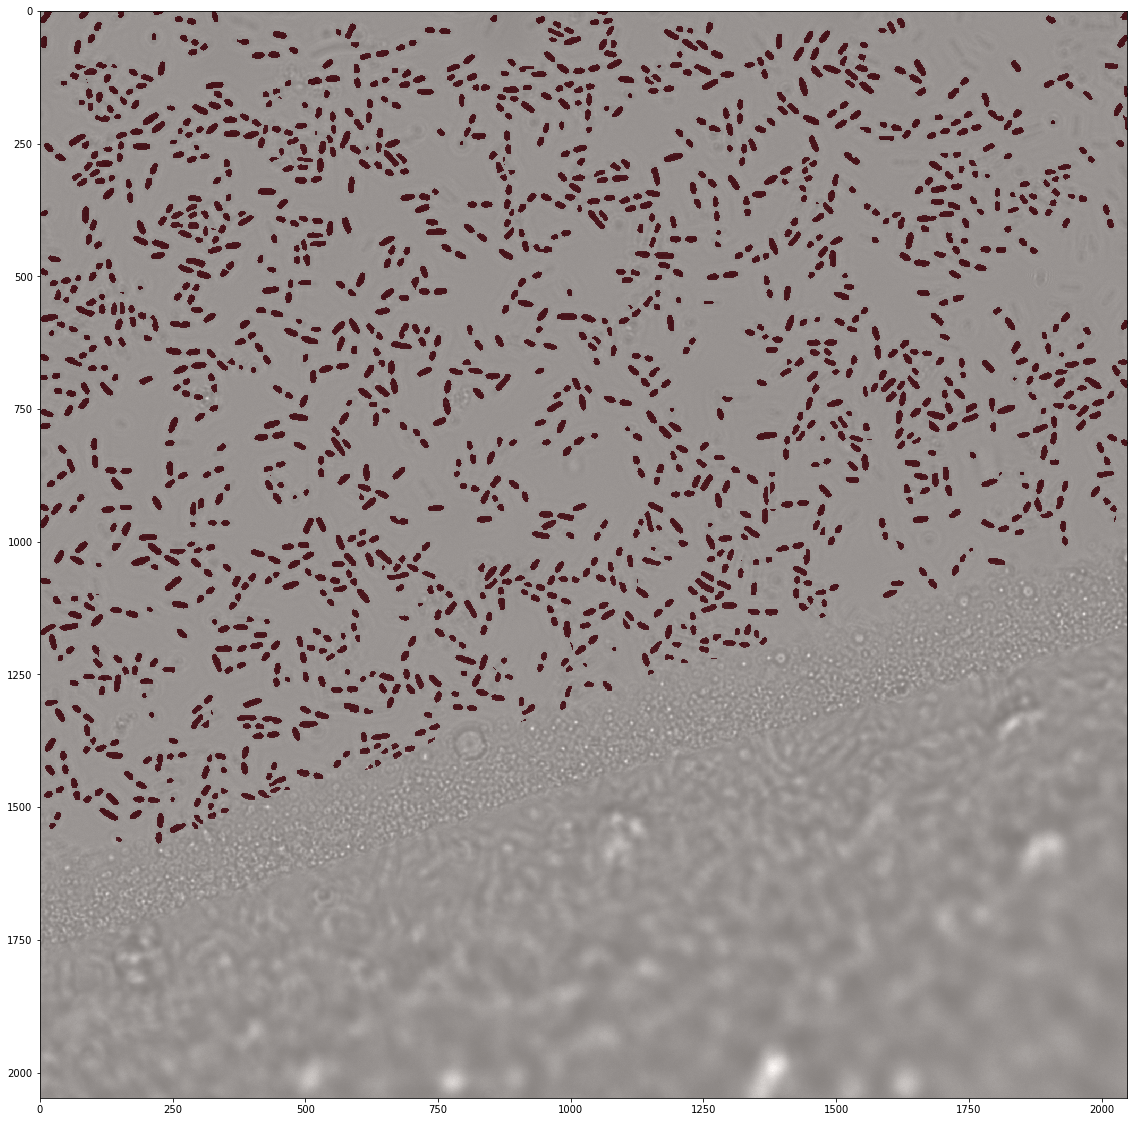

In [15]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(all_planes[:,:,20,7],cmap= 'gray')
plt.imshow(all_masks[:,:,7],alpha = 0.5,cmap='Reds')
plt.show()

In [23]:
counter_test = 0
for counter in range(len(listpos)):
    i=listpos[shuffle[counter]][0]
    j=listpos[shuffle[counter]][1]
    k=listpos[shuffle[counter]][2]
  
    #region around mid
    #mid = np.random.randint(mid_plane-3,mid_plane+3)
    init_rand = np.random.randint(0,21-10+1)
    img = all_planes[i*unitsize:(i+1)*unitsize,j*unitsize:(j+1)*unitsize,init_rand:init_rand+10,k]
    
    for m in range(img.shape[2]):
        img[:,:,m] = ndimage.gaussian_filter(img[:,:,m],3)

    meanstack = np.mean(img,axis =2)
    for m in range(img.shape[2]):
        img[:,:,m] = img[:,:,m]-meanstack
    
    img = img/np.std(img)
    
    img_mask = 255*all_masks[i*image_rows:(i+1)*image_rows,j*image_cols:(j+1)*image_cols,k]
    img_weight = all_weights[i*image_rows:(i+1)*image_rows,j*image_cols:(j+1)*image_cols,k]
      
    if multiply*counter<num_train:
        if channels==1:
            imgs[multiply*counter] = img[..., np.newaxis]
            #img = img.T
            #imgs[multiply*counter+1] = img[..., np.newaxis]
        else:
            imgs[multiply*counter] = img
            #img = np.transpose(img,(1,0,2))
            #imgs[2*counter+1] = img
        imgs_mask[multiply*counter] = img_mask
        #img_mask = img_mask.T
        #imgs_mask[2*counter+1] = img_mask
        imgs_weight[multiply*counter] = img_weight
        #img_weight = img_weight.T
        #imgs_weight[multiply*counter+1] = img_weight
    else:
        if channels==1:
            imgs_test[counter_test] = img[..., np.newaxis]
        else:
            imgs_test[counter_test] = img

        imgs_id[counter_test] = counter_test
        counter_test+=1

In [23]:
'''for i in range(imgs.shape[0]):
    randint = np.random.rand()+1
    if np.random.rand()<0.5: 
        randint = 1/randint
    imgs[i,:,:,:] = imgs[i,:,:,:]*randint'''

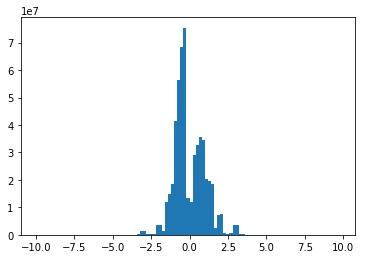

In [30]:
plt.hist(imgs.ravel(),bins = np.arange(-10,10,0.2))
plt.show()

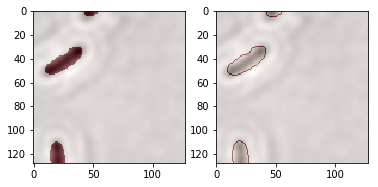

In [29]:
#check individul examples of training set
plt.subplot(1,2,1)
id = 330
plt.imshow(imgs[id,:,:,9],cmap = 'gray')
plt.imshow(np.reshape(imgs_mask[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.subplot(1,2,2)
plt.imshow(imgs[id,:,:,9],cmap = 'gray')
plt.imshow(np.reshape(imgs_weight[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.show()

In [32]:
mean_val = np.mean(imgs)

std_val = np.std(imgs)

In [33]:
std_val

0.9999999999999951

In [31]:
#save all the data structures
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
#np.save(path_to_save+'imgs_train.npy', (imgs-mean_val)/std_val)
np.save(path_to_save+'imgs_train.npy', imgs)
np.save(path_to_save+'imgs_mask_train.npy', imgs_mask.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_weight_train.npy', imgs_weight.reshape((num_train,image_cols*image_rows)))
#np.save(path_to_save+'imgs_test.npy', (imgs_test-mean_val)/std_val)
np.save(path_to_save+'imgs_test.npy', imgs_test)
np.save(path_to_save+'imgs_id_test.npy', imgs_id)